## Intersection over Union: One of Heuristics for Error Detection

In [1]:
import os
import random
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor

from tqdm import tqdm

In [2]:
images_folder_val = "bdd100k/images/100k/val"
json_labels_val = "bdd100k/labels/bdd100k_labels_images_val.json"
json_labels_err = "bdd100k/labels/bdd100k_w_errors.json"
json_error_ids = "bdd100k/labels/error_ids_dict.json"

In [3]:
with open(json_labels_val, 'r') as file:
    data_accurate = json.load(file)

with open(json_labels_err, 'r') as file:
    data_err = json.load(file)

with open(json_error_ids, 'r') as file:
    error_ids_generated_with_types = json.load(file)

In [4]:
counts = {key: len(values) for key, values in error_ids_generated_with_types.items()}
counts

{'misclassification_err': 33482,
 'size_alternation_err': 17054,
 'remove_label_err': 18601,
 'shifting_err': 7893}

In [5]:
misclassification_ids_original = set(error_ids_generated_with_types['misclassification_err'])
size_alternation_ids_original = set(error_ids_generated_with_types['size_alternation_err'])
missing_ids_original = set(error_ids_generated_with_types['remove_label_err'])
shifting_ids_original = set(error_ids_generated_with_types['shifting_err'])

def print_error_by_type_amounts():
    print(f"Miscalssified labels, amount: {len(misclassification_ids_original)}")
    print(f"Wrong bounding boxes positions, amount: {len(size_alternation_ids_original.union(shifting_ids_original))}")
    print(f"Missing labels, amount: {len(missing_ids_original)}")
    print(f"All error ids, amount: {len(size_alternation_ids_original.union(shifting_ids_original, missing_ids_original, misclassification_ids_original))}")

print_error_by_type_amounts()

Miscalssified labels, amount: 33482
Wrong bounding boxes positions, amount: 23787
Missing labels, amount: 18601
All error ids, amount: 71144


### Step 1: Compile all predefined error IDs into a set

In [6]:
def compile_error_ids(predefined_error_ids_by_type):
    all_error_ids = set()
    for ids in predefined_error_ids_by_type.values():
        all_error_ids.update(ids)
    return all_error_ids

predefined_error_ids =  compile_error_ids(error_ids_generated_with_types)
len(predefined_error_ids)

71144

### Step 2: Calculate IoUs across thresholds

In [7]:
def compute_iou(box1, box2):
    # Unpack coordinates
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    # Determine the coordinates of the intersection rectangle
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    
    # Calculate intersection area
    inter_width = max(inter_x_max - inter_x_min, 0)
    inter_height = max(inter_y_max - inter_y_min, 0)
    intersection = inter_width * inter_height
    
    # Calculate the union area
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union = box1_area + box2_area - intersection
    
    # Calculate IoU
    iou = intersection / union if union > 0 else 0
    return iou

def centroid(box):
    """ Calculate the centroid of a bounding box. """
    x_center = (box[0] + box[2]) / 2
    y_center = (box[1] + box[3]) / 2
    return x_center, y_center

def distance(c1, c2):
    """ Calculate the Euclidean distance between two centroids. """
    return np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2)

from sklearn.neighbors import KDTree
import numpy as np

def calculate_iou_errors_by_threshold_with_proximity(data_err, data_accurate, threshold_step=0.05):
    iou_thresholds = np.arange(0, 1 + threshold_step, threshold_step)
    iou_thresholds = [round(thresh, 2) for thresh in iou_thresholds] 
    threshold_to_bb_error_ids = {}

    # Precompute centroids and organize accurate labels in a KD-Tree for fast nearest neighbor search
    accurate_boxes = []
    accurate_ids = []
    for image_data_accurate in data_accurate:
        for label_data_accurate in image_data_accurate['labels']:
            box = [label_data_accurate['box2d']['x1'], label_data_accurate['box2d']['y1'],
                   label_data_accurate['box2d']['x2'], label_data_accurate['box2d']['y2']]
            centroid = [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]  # Calculate centroid
            accurate_boxes.append(centroid)
            accurate_ids.append(box)

    tree = KDTree(accurate_boxes)

    for threshold in tqdm(iou_thresholds, desc="Calculating IoUs for thresholds"):
        error_ids = set()
        
        for image_data_err in data_err:
            for label_data_err in image_data_err['labels']:
                err_box = [label_data_err['box2d']['x1'], label_data_err['box2d']['y1'],
                           label_data_err['box2d']['x2'], label_data_err['box2d']['y2']]
                err_centroid = [(err_box[0] + err_box[2]) / 2, (err_box[1] + err_box[3]) / 2]

                # Find the nearest centroid from KD-Tree
                dist, idx = tree.query([err_centroid], k=1)
                closest_pred = accurate_ids[idx[0][0]]

                # Compute IoU with the closest box
                iou = compute_iou(err_box, closest_pred)
                if iou > threshold:
                    error_ids.add(label_data_err['id'])

        threshold_to_bb_error_ids[threshold] = error_ids

    return threshold_to_bb_error_ids

# Takes ~4min
threshold_to_bb_error_ids = calculate_iou_errors_by_threshold_with_proximity(data_err, data_accurate, 0.05)
len(threshold_to_bb_error_ids[0.5])

Calculating IoUs for thresholds: 100%|█████████████████████████████████████████████████| 21/21 [04:04<00:00, 11.64s/it]


148264

In [8]:
len(threshold_to_bb_error_ids[1])

0

In [9]:
print_error_by_type_amounts() # Wrong bounding boxes positions

Miscalssified labels, amount: 33482
Wrong bounding boxes positions, amount: 23787
Missing labels, amount: 18601
All error ids, amount: 71144


### Step 3: Find Missing Labels

In [10]:
def find_missing_labels(data_err, data_accurate):
    # Convert list of images to dictionary by image name for quick lookup
    data_err_dict = {image['name']: image for image in data_err}
    
    missing_labels = set()
    
    # Iterate through each image in the accurate data
    for image_accurate in tqdm(data_accurate, desc="Finding missing labels"):
        image_name = image_accurate['name']
        accurate_labels = {label['id']: label for label in image_accurate['labels']}
        
        # Check if the image exists in the error data
        if image_name in data_err_dict:
            error_labels = {label['id']: label for label in data_err_dict[image_name]['labels']}
            
            # Compare label IDs in both sets
            for label_id in accurate_labels:
                if label_id not in error_labels:
                    missing_labels.add(label_id)
       
    
    return missing_labels

missing_ids = find_missing_labels(data_err, data_accurate)
len(missing_ids)

Finding missing labels: 100%|████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 113628.59it/s]


18619

In [11]:
print_error_by_type_amounts() # Missing labels

Miscalssified labels, amount: 33482
Wrong bounding boxes positions, amount: 23787
Missing labels, amount: 18601
All error ids, amount: 71144


### Step 4:  Find Misclassified Labels

In [12]:
def function_find_misclassified_labels(data_err, data_accurate):
    misclassified_ids = set()
    
    # Create a dictionary for quick lookup of predicted categories by image name and label ID
    pred_categories = {}
    for image_data in data_accurate:
        image_name = image_data['name']
        if 'labels' in image_data:
            for label_data in image_data['labels']:
                label_id = label_data['id']
                category = label_data.get('category', None)
                pred_categories[(image_name, label_id)] = category

    # Loop through erroneous data to find mismatches
    for image_data in tqdm(data_err, desc="Checking for misclassification errors"):
        image_name = image_data['name']
        if 'labels' in image_data:
            for label_data in image_data['labels']:
                label_id = label_data['id']
                err_category = label_data.get('category', None)
                # Check if there's a corresponding predicted category and if it mismatches
                if (image_name, label_id) in pred_categories and pred_categories[(image_name, label_id)] != err_category:
                    misclassified_ids.add(label_id)
    
    return misclassified_ids

misclassified_ids = function_find_misclassified_labels(data_err, data_accurate)
len(misclassified_ids)

Checking for misclassification errors: 100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 89279.83it/s]


33482

In [13]:
print_error_by_type_amounts() # Miscalssified labels

Miscalssified labels, amount: 33482
Wrong bounding boxes positions, amount: 23787
Missing labels, amount: 18601
All error ids, amount: 71144


### Step 5: Combine Error Type ids across Thresholds

In [14]:
def update_error_ids_with_missing_and_misclassified(threshold_to_bb_error_ids, missing_label_ids, misclassified_label_ids):
    # Convert lists to sets for each threshold and update with missing and misclassified IDs
    threshold_to_all_error_ids = {}
    
    for threshold, error_ids in threshold_to_bb_error_ids.items():
        # Start with the current set of error IDs from IoU calculations
        updated_ids = set(error_ids)
        
        # Add missing and misclassified label IDs
        updated_ids.update(missing_label_ids)
        updated_ids.update(misclassified_label_ids)
        
        # Store the updated set back into the dictionary
        threshold_to_all_error_ids[threshold] = updated_ids
        
    return threshold_to_all_error_ids

threshold_to_all_error_ids = update_error_ids_with_missing_and_misclassified(threshold_to_bb_error_ids, missing_ids, misclassified_ids)

In [15]:
print_error_by_type_amounts() # Wrong bounding boxes positions

Miscalssified labels, amount: 33482
Wrong bounding boxes positions, amount: 23787
Missing labels, amount: 18601
All error ids, amount: 71144


In [16]:
print(f"Before combining: {len(threshold_to_bb_error_ids[1])}") 
print(f"After: {len(threshold_to_all_error_ids[1])}") 

Before combining: 0
After: 52101


### Step 6: Calculate Match Percentage

In [17]:
def calculate_recall(detected_error_ids, true_error_ids):
    """
    Calculate recall, which is the percentage of actual errors that were detected.
    
    Args:
    detected_error_ids (list of str): The error IDs detected by the model.
    true_error_ids (list of str): The predefined true error IDs.
    
    Returns:
    float: The recall percentage, representing how many true errors were detected.
    """
    detected_error_set = set(detected_error_ids)
    true_error_set = set(true_error_ids)
    true_positives = detected_error_set & true_error_set
    if len(true_error_set) > 0:
        recall = len(true_positives) / len(true_error_set) * 100
    else:
        recall = 0  # Avoid division by zero; though, there should always be some true errors
    return recall

# Function to calculate recall for each IoU threshold
def calculate_recall_across_thresholds(threshold_to_error_ids, true_error_ids):
    recall_results = {}
    for threshold, error_ids in threshold_to_error_ids.items():
        recall = calculate_recall(error_ids, true_error_ids)
        recall_results[threshold] = recall
    return recall_results
    

def calculate_precision(detected_error_ids, true_error_ids):
    """
    Calculate precision, which is the percentage of detected errors that are actual errors.
    
    Args:
    detected_error_ids (list of str): The error IDs detected by the model.
    true_error_ids (list of str): The predefined true error IDs.
    
    Returns:
    float: The precision percentage, representing how accurate the detections were.
    """
    detected_error_set = set(detected_error_ids)
    true_error_set = set(true_error_ids)
    true_positives = detected_error_set & true_error_set
    if len(detected_error_set) > 0:
        precision = len(true_positives) / len(detected_error_set) * 100
    else:
        precision = 0  # Avoid division by zero; this can occur if no errors are detected
    return precision

def calculate_precision_across_thresholds(threshold_to_error_ids, true_error_ids):
    precision_results = {}
    for threshold, error_ids in threshold_to_error_ids.items():
        precision = calculate_precision(error_ids, true_error_ids)
        precision_results[threshold] = precision
    return precision_results


def calculate_f1_score(precision, recall):
    """
    Calculate the F1 score, which is the harmonic mean of precision and recall.
    
    Args:
    precision (float): The precision percentage.
    recall (float): The recall percentage.
    
    Returns:
    float: The F1 score.
    """
    if (precision + recall) > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0  # Avoid division by zero; occurs if both precision and recall are zero
    return f1_score

def calculate_f1_score_across_thresholds(precision_results, recall_results):
    f1_scores = {}
    for threshold in precision_results:
        f1_score = calculate_f1_score(precision_results[threshold], recall_results[threshold])
        f1_scores[threshold] = f1_score
    return f1_scores

# Assuming threshold_to_all_error_ids and predefined_error_ids are defined elsewhere
recall_metrics_over_thresholds = calculate_recall_across_thresholds(threshold_to_all_error_ids, predefined_error_ids)
precision_metrics_over_thresholds = calculate_precision_across_thresholds(threshold_to_all_error_ids, predefined_error_ids)
f1_score_over_thresholds= calculate_f1_score_across_thresholds(precision_metrics_over_thresholds, recall_metrics_over_thresholds)

In [18]:
len(threshold_to_all_error_ids[0.5]) / len(predefined_error_ids)

2.399120094456314

### Step 7(Final): Plot Accuracy Over Thresholds, Plot Precision and Recall

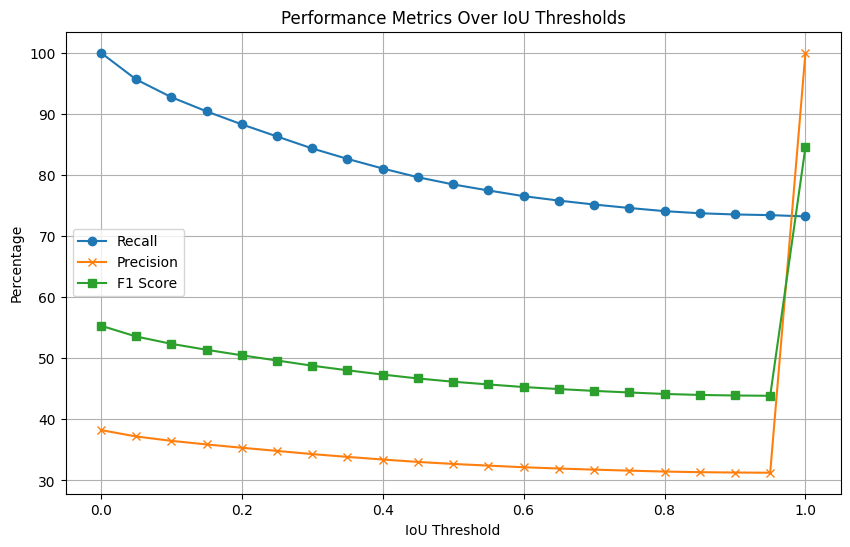

In [19]:
def plot_metrics(thresholds, recall_metrics, precision_metrics, f1_scores):
    """
    Plots recall, precision, and F1 scores across different thresholds.
    
    Args:
    thresholds (list of float): The IoU thresholds.
    recall_metrics (dict of float): Recall values keyed by threshold.
    precision_metrics (dict of float): Precision values keyed by threshold.
    f1_scores (dict of float): F1 scores keyed by threshold.
    """
    # Extracting the values and sorting by threshold for consistent plotting
    thresholds = sorted(thresholds)
    recalls = [recall_metrics[t] for t in thresholds]
    precisions = [precision_metrics[t] for t in thresholds]
    f1s = [f1_scores[t] for t in thresholds]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='x')
    plt.plot(thresholds, f1s, label='F1 Score', marker='s')
    plt.xlabel('IoU Threshold')
    plt.ylabel('Percentage')
    plt.title('Performance Metrics Over IoU Thresholds')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example of how to use the plotting function
threshold_list = list(threshold_to_all_error_ids.keys())  # Assuming thresholds are the same for all metrics
plot_metrics(threshold_list, recall_metrics_over_thresholds, precision_metrics_over_thresholds, f1_score_over_thresholds)

### Plot Confusion Matrices

In [20]:
def calculate_confusion_matrix(detected_error_ids, true_error_ids):
    """
    Calculate the confusion matrix elements for error detection.
    
    Args:
    detected_error_ids (list of str): The error IDs detected by the model.
    true_error_ids (list of str): The predefined true error IDs.
    
    Returns:
    dict: A dictionary containing TP, FP, and FN counts.
    """
    detected_error_set = set(detected_error_ids)
    true_error_set = set(true_error_ids)
    
    # True Positives: Errors detected by the model that are actual errors
    true_positives = detected_error_set & true_error_set
    
    # False Positives: Errors detected by the model that are not actual errors
    false_positives = detected_error_set - true_error_set
    
    # False Negatives: Actual errors not detected by the model
    false_negatives = true_error_set - detected_error_set
    
    return {
        'TP': len(true_positives),
        'FP': len(false_positives),
        'FN': len(false_negatives)
    }

# Function to calculate the confusion matrix for each IoU threshold
def calculate_confusion_matrices_across_thresholds(threshold_to_error_ids, true_error_ids):
    confusion_matrices = {}
    for threshold, error_ids in threshold_to_error_ids.items():
        confusion_matrix = calculate_confusion_matrix(error_ids, true_error_ids)
        confusion_matrices[threshold] = confusion_matrix
    return confusion_matrices

# Assuming threshold_to_all_error_ids and predefined_error_ids are defined elsewhere
confusion_matrices_over_thresholds = calculate_confusion_matrices_across_thresholds(threshold_to_all_error_ids, predefined_error_ids)

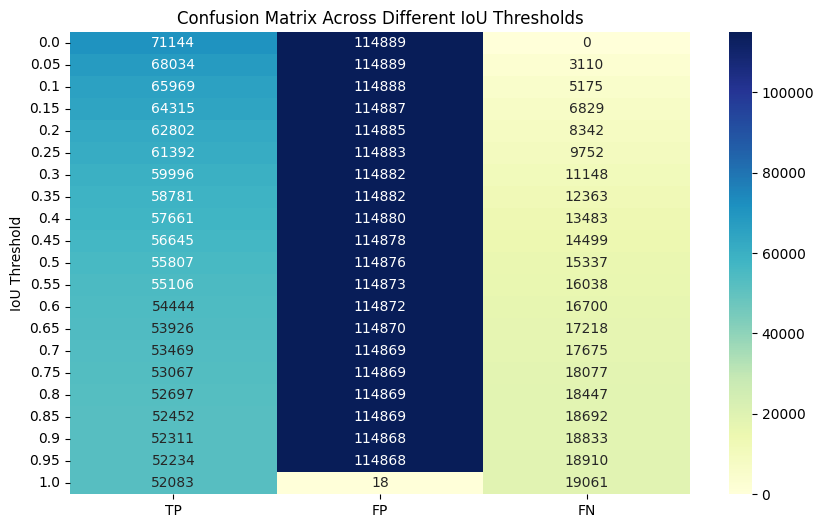

In [21]:
import seaborn as sns
import pandas as pd

def plot_confusion_matrices(confusion_matrices):
    # Prepare data for plotting
    data = []
    thresholds = sorted(confusion_matrices.keys())
    for threshold in thresholds:
        cm = confusion_matrices[threshold]
        data.append([threshold, cm['TP'], cm['FP'], cm['FN']])

    # Convert data into DataFrame for easier plotting
    df = pd.DataFrame(data, columns=['Threshold', 'TP', 'FP', 'FN'])
    df.set_index('Threshold', inplace=True)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
    plt.title('Confusion Matrix Across Different IoU Thresholds')
    plt.ylabel('IoU Threshold')
    plt.show()

# Assuming confusion_matrices_over_thresholds is already defined
plot_confusion_matrices(confusion_matrices_over_thresholds)